In [ ]:
# import library to build our model
import os
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input


# plotting
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
width=150; height=150
batch_size=32

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# training directory 
TRAINING_DIR = '/content/gdrive/MyDrive/1. Colab Notebooks/semester 7/Pembelajaran Mesin/Tugas Besar/Dataset/Splitted 2/train'
# training generator 
image_DataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode = 'reflect')

train_generator = image_DataGenerator.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(height, width),
                                                    )                                            

# validation generator
VALIDATION_DIR = '/content/gdrive/MyDrive/1. Colab Notebooks/semester 7/Pembelajaran Mesin/Tugas Besar/Dataset/Splitted 2/val'

validation_generator = image_DataGenerator.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(height, width)
                                                             )

Found 2000 images belonging to 5 classes.
Found 404 images belonging to 5 classes.


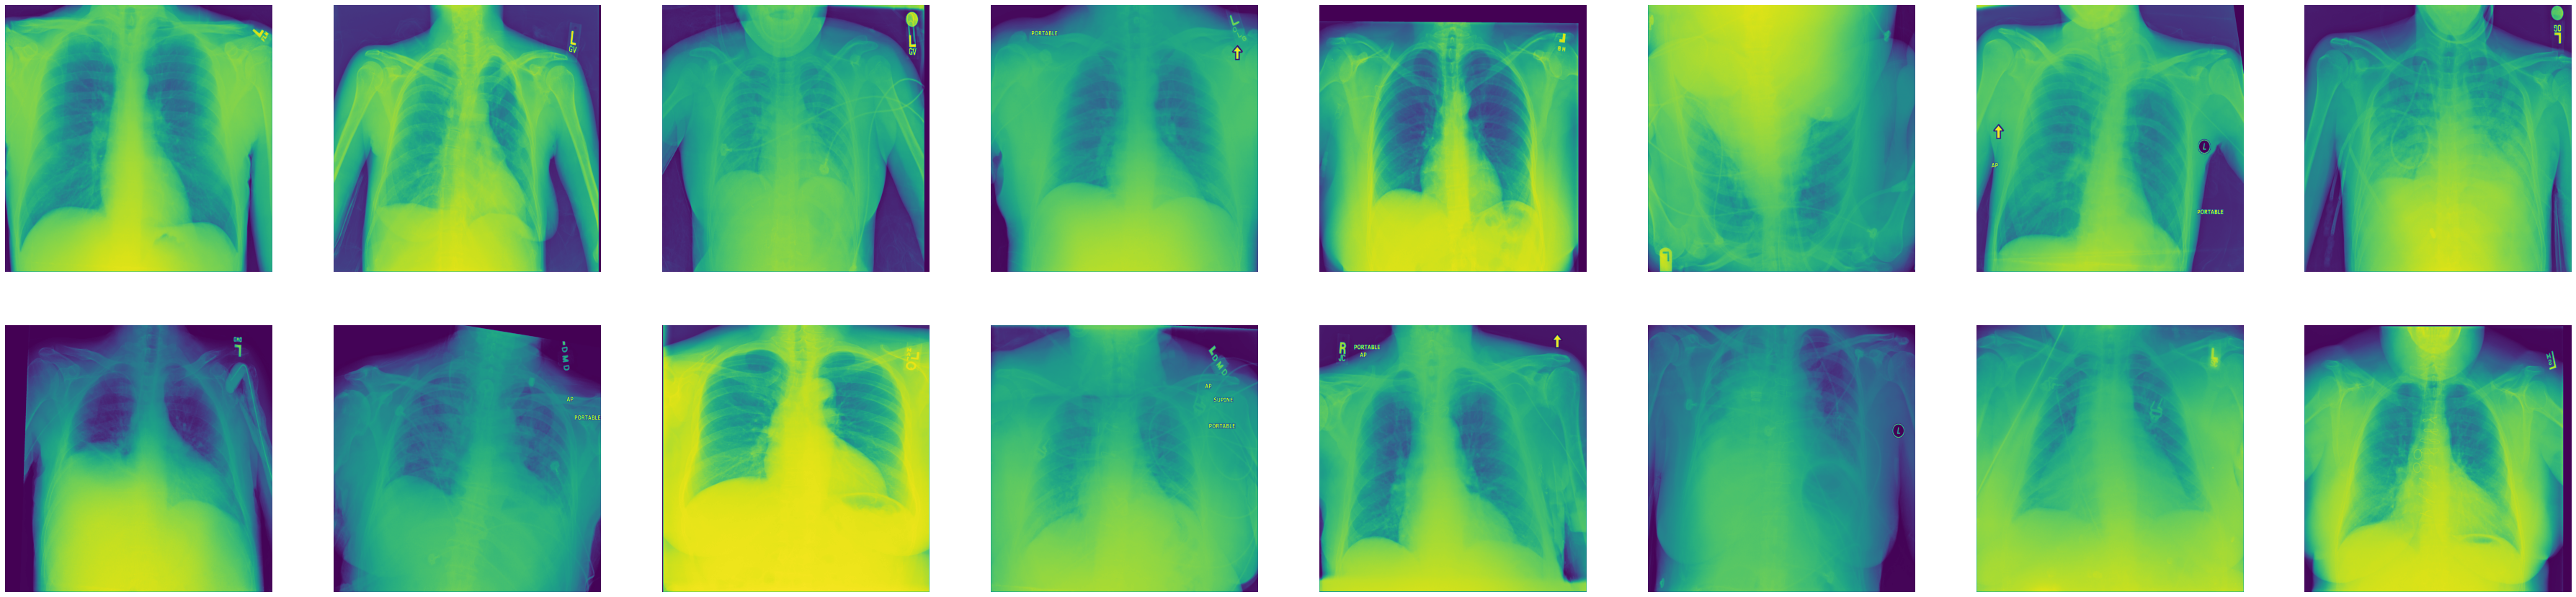

In [ ]:

augmentasi_dir = "/content/gdrive/MyDrive/1. Colab Notebooks/semester 7/Pembelajaran Mesin/Tugas Besar/Dataset/Splitted 2/train/No_findings"
augmentasi_fname = os.listdir(augmentasi_dir)

nrows = 8
ncols = 8

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 8, nrows * 8)

pic_index += 16
next_augmentasi_pix = [os.path.join(augmentasi_dir, fname) 
                for fname in augmentasi_fname[pic_index-16:pic_index]]

for i, img_path in enumerate(next_augmentasi_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

In [ ]:
# setting Callback so we can save the best model in format h5 and i save it in my drive
callbacks = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')        
directory_to_save_best_model_file = '/content/gdrive/MyDrive/1. Colab Notebooks/semester 7/Pembelajaran Mesin/Tugas Besar/2. Modelling CNN 2/model_drop_batch_weight_from_callback_VGG16.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [ ]:
# import pretrain model in this case i use Resnet Model and setting the parameter "include_top" to false so i can change it
VGG16_base = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',
                                              input_tensor=None, input_shape=(height, width,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# i add some of layer and setting dropout more big to avoid Overffiting in my model
print('Adding new layers')
output = VGG16_base.get_layer(index = -1).output  
output = Flatten()(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(5, activation='softmax')(output) 
print('New layers Finishing Added!!!!')

Adding new layers
New layers Finishing Added!!!!


In [ ]:
# let's loojk to the arcitecture of the model that build
VGG16_model = Model(VGG16_base.input, output)
for layer in VGG16_model.layers[:-7]:
    layer.trainable = False

VGG16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# compile the model and set loss parameter to "catagorical_crossentropy" because we have more of 2 class to clasify

VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='categorical_crossentropy', 
                        metrics =['accuracy'])

In [ ]:
# lets train model and set some of parameter like a epoch , in this case i set the epoch in 30 because i thing is more enough
history = VGG16_model.fit_generator(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [callbacks, best_model]
                              )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
63/63 [==============================] - 587s 9s/step - loss: 1.2709 - accuracy: 0.6565 - val_loss: 4.3813 - val_accuracy: 0.4802

Epoch 00001: val_accuracy improved from -inf to 0.48020, saving model to /content/gdrive/MyDrive/1. Colab Notebooks/semester 7/Pembelajaran Mesin/Tugas Besar/2. Modelling CNN 2/model_drop_batch_weight_from_callback_VGG16.h5
Epoch 2/50
63/63 [==============================] - 64s 1s/step - loss: 0.9730 - accuracy: 0.7275 - val_loss: 1.0791 - val_accuracy: 0.7525

Epoch 00002: val_accuracy improved from 0.48020 to 0.75248, saving model to /content/gdrive/MyDrive/1. Colab Notebooks/semester 7/Pembelajaran Mesin/Tugas Besar/2. Modelling CNN 2/model_drop_batch_weight_from_callback_VGG16.h5
Epoch 3/50
63/63 [==============================] - 62s 991ms/step - loss: 0.7700 - accuracy: 0.7635 - val_loss: 0.7683 - val_accuracy: 0.7896

Epoch 00003: val_accuracy improved from 0.75248 to 0.78960, saving model to /content/gdrive/MyDrive/1. Colab Notebooks/sem

In [ ]:
# save the model in h5 format to deploy
target_dir = '/content/gdrive/MyDrive/1. Colab Notebooks/semester 7/Pembelajaran Mesin/Tugas Besar/2. Modelling CNN 2/model_drop_batch_weight_from_callback_VGG16.h5'
if not os.path.exists(target_dir):  
  os.mkdir(target_dir)
VGG16_model.save(target_dir + 'VGG16_model_1.h5')
VGG16_model.save_weights(target_dir + 'VGG16_weights_1.h5')

In [ ]:
# lets set some of parameter in metric accuracy to look the graph when training the model
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

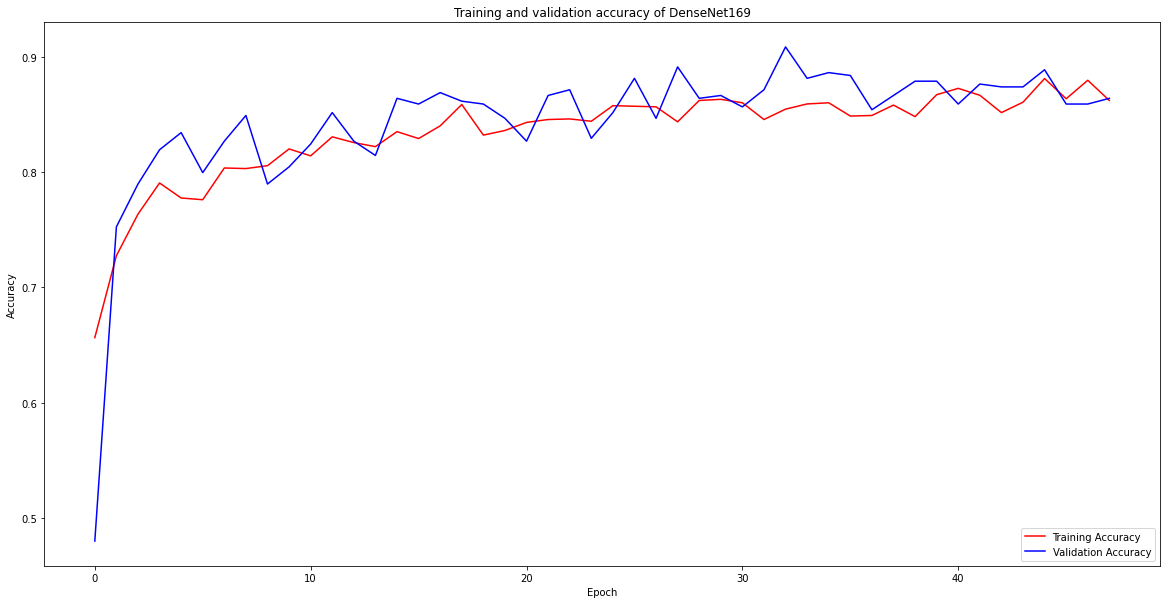

In [ ]:
# plot the training and validation accuracy model
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy of DenseNet169')
#plt.ylim([0.7, 1])
plt.legend(loc='lower right')
#plt.show()
# fig.savefig('/content/gdrive/MyDrive/1. Colab Notebooks/Skripsi/model DenseNet/DenseNet 169/Accuracy_curve_densenet.jpg')

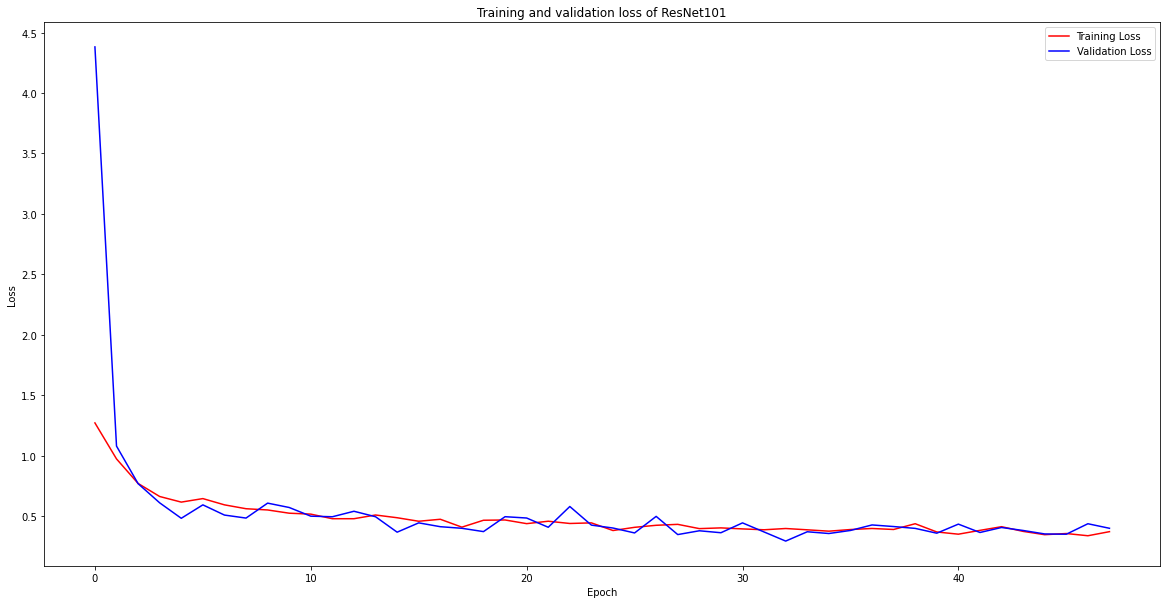

In [ ]:
# ploting the training and validation loss
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss of ResNet101')
fig2.savefig('/content/gdrive/MyDrive/1. Colab Notebooks/Skripsi/model DenseNet/DenseNet 169/Loss_curve_densenet.jpg')

In [ ]:
# import some of library to evaluate model
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import some of library that we need to look the confusion matrix, recall, f1_score, and accuracy score to look how much your model is well
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns
sns.set(style='whitegrid')

In [ ]:
# loading model to evaluate more depth
from keras.models import load_model
model_path = '/content/gdrive/MyDrive/1. Colab Notebooks/semester 7/Pembelajaran Mesin/Tugas Besar/2. Modelling CNN 2/model_drop_batch_weight_from_callback_VGG16.h5'
model = load_model(model_path)

Found 24 images belonging to 5 classes.
1/1 [==============================] - 1s 519ms/step
Accuracy  : 0.75
Precision : 0.7638888888888888
f1Score : 0.7533670033670035
[[4 1 0 0 0]
 [0 3 0 0 1]
 [0 0 4 1 0]
 [0 0 0 4 1]
 [0 0 1 1 3]]


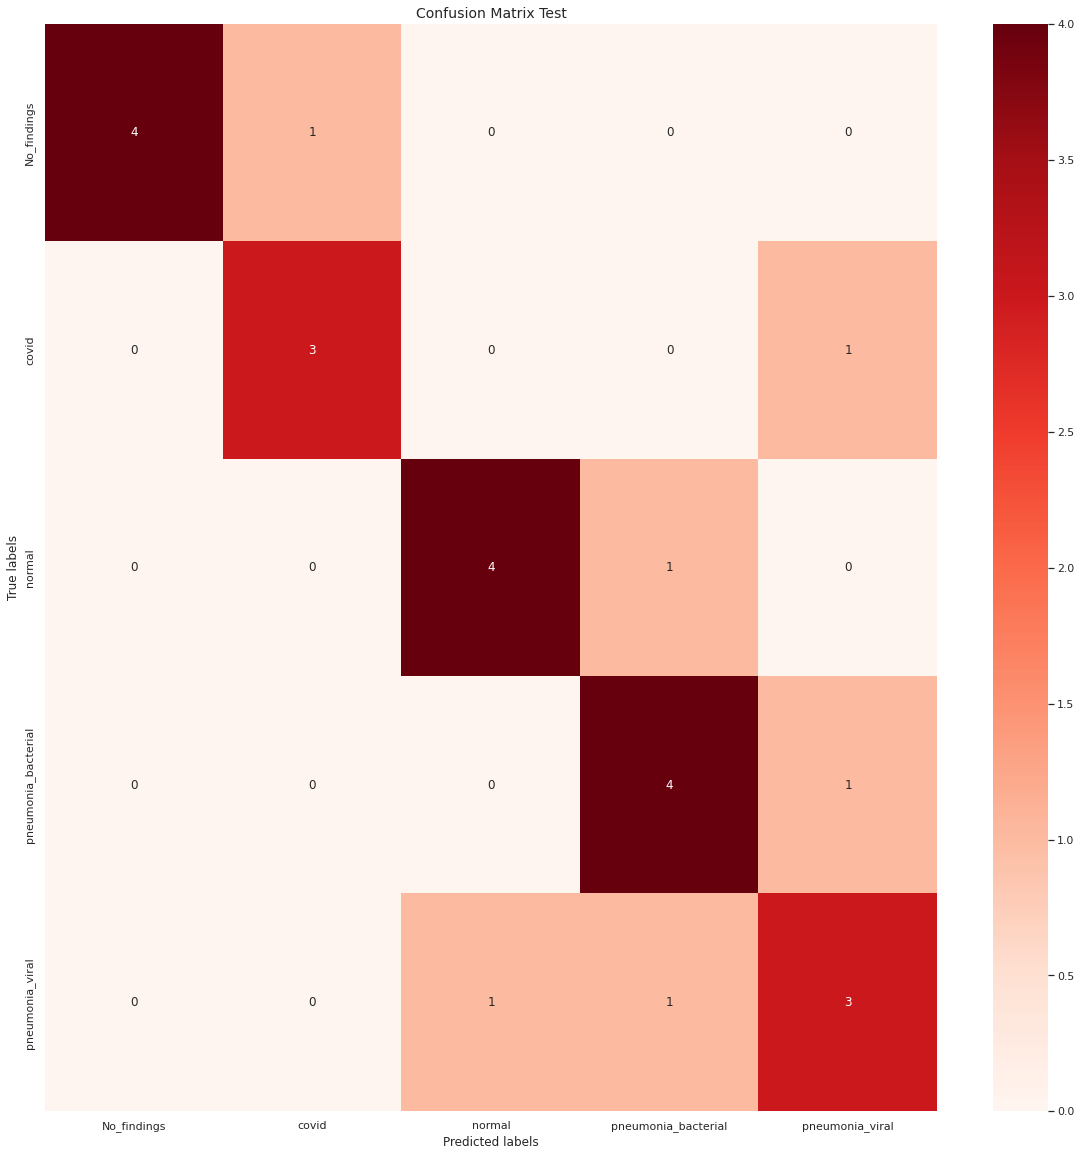

In [ ]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

height=150; width=150
batch_size=32

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

TESTING_DIR = '/content/gdrive/MyDrive/1. Colab Notebooks/semester 7/Pembelajaran Mesin/Tugas Besar/Dataset/Splitted 2/test'

test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size=batch_size,                                                             
                                                  target_size=(height, width),
                                                  class_mode= None,
                                                  shuffle=False
                                                  )

predictions = model.predict(test_generator, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(20,20))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(5,5)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, yPredictions, target_names=class_names))

                     precision    recall  f1-score   support

        No_findings       1.00      0.80      0.89         5
              covid       0.75      0.75      0.75         4
             normal       0.80      0.80      0.80         5
pneumonia_bacterial       0.67      0.80      0.73         5
    pneumonia_viral       0.60      0.60      0.60         5

           accuracy                           0.75        24
          macro avg       0.76      0.75      0.75        24
       weighted avg       0.76      0.75      0.75        24

